In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Denoising Autoencoder
In this lab, you will be applying a noise filter to MNIST images and using a denoising autoencoder to reconstruct the original image.

In [8]:
def masking_noise(X, v):
    """ Apply masking noise to data in X, in other words a fraction v of elements of X
    (chosen at random) is forced to zero."""
    
    X_noise = X.copy()

    n_samples = X.shape[0]
    n_features = X.shape[1]

    for i in range(n_samples):
        mask = np.random.choice(range(n_features), int(v*n_features), replace=False)
        for m in mask:
            X_noise[i][m] = 0.
    return X_noise

<img src="files/ae_diagram.png">

# Network parameters and Hyperparameters

In [34]:
# Parameters
learning_rate = 0.01
training_epochs = 5
batch_size = 256

# Network Parameters
n_hidden_1 = 256 # 1st layer num features
n_hidden_2 = 128 # 2nd layer num features
n_input = 784 # MNIST data input (img shape: 28*28)

Create a placeholder value for the input images after they are flattened to an array of dimension 784.

In [11]:
X = tf.placeholder(tf.float32, shape=(None, n_input))
X_noise = tf.placeholder(tf.float32, shape=(None, n_input))

Fill in the weights and biases dictionary for all the layers.

Fill in the encoder and decoder functions:
* The encoder function takes in a noisy image and returns a 128 dimensional tensor (the middle layer)
* The decoder function takes in the middle layer of the network and outputs the restored image

In [16]:
weights = {
    'encoder_w1': tf.Variable(tf.truncated_normal([n_input, n_hidden_1], stddev=0.1)),
    'encoder_w2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2], stddev=0.1)),
    'decoder_w1': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_1], stddev=0.1)),
    'decoder_w2': tf.Variable(tf.truncated_normal([n_hidden_1, n_input], stddev=0.1))
}

bias = {
    "encoder_b1": tf.Variable(tf.truncated_normal([1, n_hidden_1], stddev=0.1)),
    "encoder_b2": tf.Variable(tf.truncated_normal([1, n_hidden_2], stddev=0.1)),
    "decoder_b1": tf.Variable(tf.truncated_normal([1, n_hidden_1], stddev=0.1)),
    "decoder_b2": tf.Variable(tf.truncated_normal([1, n_input], stddev=0.1))
}

def encoder(X):
    layer1 = tf.nn.sigmoid(tf.matmul(X, weights['encoder_w1']) + bias['encoder_b1'])
    layer2 = tf.nn.sigmoid(tf.matmul(layer1, weights['encoder_w2']) + bias['encoder_b2'])
    return layer2
    
def decoder(x):
    layer1 = tf.nn.sigmoid(tf.matmul(x, weights['decoder_w1']) + bias['decoder_b1'])
    layer2 = tf.nn.sigmoid(tf.matmul(layer1, weights['decoder_w2']) + bias['decoder_b2'])
    return layer2

Create the encoder and decoder layers using the functions above.

In [17]:
encoder_op = encoder(X_noise)
decoder_op = decoder(encoder_op)

pred = decoder_op

Calculate the entropy by taking the Log Loss and calculate the overall loss by taking the mean of the entropy. The predicted value of this network is the output of the decoder and the true value is the original MNIST image *before* the noise filter is added.

In [19]:
entropy = tf.losses.log_loss(labels=X, predictions=decoder_op)
loss = tf.reduce_mean(entropy)

Define the optimizer as the RMSPropOptimizer which minimizes the loss calculated above.

In [20]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)

In [21]:
from tensorflow.examples.tutorials.mnist import input_data
MNIST = input_data.read_data_sets("../data/mnist", one_hot = True)

Extracting ../data/mnist/train-images-idx3-ubyte.gz
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz


Start an interactive session and initialize all the variables created above.

In [23]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

For each training epoch, take a batch of the training examples, apply the noise filter to each image, and run the optimizer and loss. At the end of each epoch, print the loss and confirm it decreases with each epoch. 

In [35]:
num_batches = int(MNIST.train.num_examples/batch_size)

for epoch in range(training_epochs):
    total_loss = 0
    for batch in range(num_batches):
        x, _ = MNIST.train.next_batch(batch_size)
        x_noise = masking_noise(x, 0.1)
        _, l = sess.run([optimizer, loss], feed_dict={X_noise: x_noise, X: x})
        total_loss += l
    print("Epoch {0}: {1}".format(epoch, total_loss))

Epoch 0: 23.008782006800175
Epoch 1: 20.38760719448328
Epoch 2: 19.551144406199455
Epoch 3: 19.041027955710888
Epoch 4: 18.657109938561916


Use the code below to plot the original image, the noisy image, and the reconstructed image.

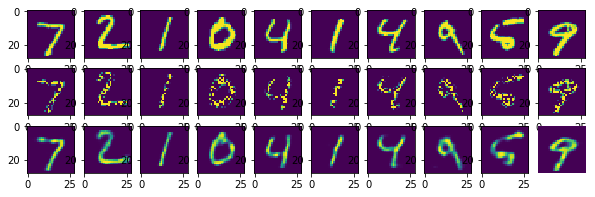

In [36]:
x = MNIST.test.images[:10]
x_noise = masking_noise(x, 0.5)
pred_img = sess.run(pred, feed_dict = {X: x, X_noise:x_noise})
f, a = plt.subplots(3, 10, figsize=(10, 3))
plt.axis('off')
for i in range(10):
    a[0][i].imshow(np.reshape(x[i], (28, 28)))
    a[1][i].imshow(np.reshape(x_noise[i], (28, 28)))
    a[2][i].imshow(np.reshape(pred_img[i], (28, 28)))
plt.show()
        

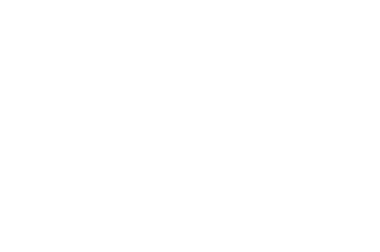

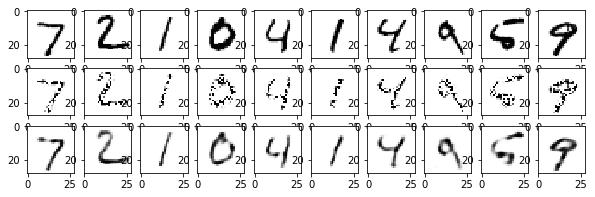

In [37]:
plt.axis('off')
f, a = plt.subplots(3, 10, figsize=(10, 3))
for i in range(10):
    a[0][i].imshow(np.reshape(x[i], (28, 28)), cmap='Greys',  interpolation='nearest')
    a[1][i].imshow(np.reshape(x_noise[i], (28, 28)), cmap='Greys',  interpolation='nearest')
    a[2][i].imshow(np.reshape(pred_img[i], (28, 28)), cmap='Greys',  interpolation='nearest')
plt.show()